In this notebook we will study the energy conservation properties of several high-order methods for a system with the following Hamiltonian:
$$
\mathcal{H}\left(q_0,q_2,p_0,p_2\right) = \frac{A}{2} \left(p_0^2 + p_2^2 + q_0^2 + q_2^2\right) + \frac{B}{\sqrt{2}} q_0 \left(3q_2^2 - q_0^2\right) + \frac{D}{4} \left(q_0^2+q_2^2\right)^2
$$
This Hamiltonian resembles the Hénon-Heiles one, but it has an additional fourth order term.
The aim of this benchmark is to see what happens with the energy error when highly accurate solutions are needed and how the results compare with the Hénon-Heiles case.

In [1]:
using DifferentialEquations, Plots
pyplot()

@inline V(q₀, q₂) = A / 2 * (q₀^2 + q₂^2) + B / √2 * q₀ * (3 * q₂^2 - q₀^2) + D / 4 * (q₀^2 + q₂^2)^2;
@inline T(p₀, p₂) = A / 2 * (p₀^2 + p₂^2);
@inline H(q₀, q₂, p₀, p₂) = T(p₀, p₂) + V(q₀, q₂);

function defineProblem(q0, p0, tspan)
  # Parameters
  A, B, D = 1., 0.55, 0.4
  function HamiltonEqs_q(t, q, p, dq)
    p₀, p₂ = p
    dq[1] = A * p₀
    dq[2] = A * p₂
  end

  function HamiltonEqs_p(t, q, p, dp)
    q₀, q₂ = q
    dp[1] = -A * q₀ - 3 * B / √2 * (q₂^2 - q₀^2) - D * q₀ * (q₀^2 + q₂^2)
    dp[2] = -q₂ * (A + 3 * √2 * B * q₀ + D * (q₀^2 + q₂^2))
  end

  prob = DynamicalODEProblem{true}(HamiltonEqs_q, HamiltonEqs_p, q0, p0, tspan)
end

h_eqs = @ode_def_noinvjac HamiltEqs begin
  dq₀ = A * p₀
  dq₂ = A * p₂
  dp₀ = -A * q₀ - 3 * B / √2 * (q₂^2 - q₀^2) - D * q₀ * (q₀^2 + q₂^2)
  dp₂ = -q₂ * (A + 3 * √2 * B * q₀ + D * (q₀^2 + q₂^2))
end A=>1 B=>0.55 D=>0.4

A, B, D = 1, 0.55, 0.4
q0 = [-4.957945055210106, -0.5767626984114834];
p0 = [0.0, 0.0];
u0 = hcat(q0, p0)

function g(u, resid)
    resid[1] = H(u[1],u[2],u[3],u[4]) - E
    resid[2:4] .= 0
end

cb = ManifoldProjection(g);

E = H(u0[1],u0[2],u0[3],u0[4])

119.99999999999999

For the comparison we will use the following function

In [2]:
function compare(; tmax=1e2, maxiters=1e10, saveat=[])
    prob1 = ODEProblem(h_eqs, u0, (0., tmax))
    prob2 = defineProblem(q0, p0, (0., tmax))
    @time sol1 = solve(prob1, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    @time sol2 = solve(prob2, KahanLi8(), dt=1e-2, maxiters=maxiters, saveat=saveat);
    @time sol3 = solve(prob2, Vern9(), abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    @time sol4 = solve(prob2, DPRKN12(), abstol=1e-14, reltol=1e-14, maxiters=maxiters);
    
    println("Vern9 + ManifoldProjection max energy error: ", maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol1.u) .- E)))
    println("KahanLi8 max energy error: ",                   maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol2.u) .- E)))
    println("Vern9 max energy error: ",                      maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol3.u) .- E)))
    println("DPRKN12 max energy error: ",                    maximum(abs.(map(u->H(u[1],u[2],u[3],u[4]), sol4.u) .- E)))
    
    plot(xlabel="t", ylabel="Energy error")
    plot!(sol1.t, map(u->H(u[1],u[2],u[3],u[4]), sol1.u) .- E, label="Vern9 + ManifoldProjection")
    plot!(sol2.t, map(u->H(u[1],u[2],u[3],u[4]), sol2.u) .- E, label="KahanLi8")
    plot!(sol3.t, map(u->H(u[1],u[2],u[3],u[4]), sol3.u) .- E, label="Vern9")
    plot!(sol4.t, map(u->H(u[1],u[2],u[3],u[4]), sol4.u) .- E, label="DPRKN12")
end

compare (generic function with 1 method)

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error. 

  0.122095 seconds (1.35 M allocations: 74.055 MiB, 30.77% gc time)
  0.070514 seconds (250.54 k allocations: 19.345 MiB, 16.88% gc time)
  0.481225 seconds (7.60 M allocations: 144.500 MiB, 44.16% gc time)
  0.027476 seconds (86.68 k allocations: 4.968 MiB, 40.98% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 5.7553961596568115e-12
Vern9 max energy error: 1.3358203432289883e-12
DPRKN12 max energy error: 8.952838470577262e-13



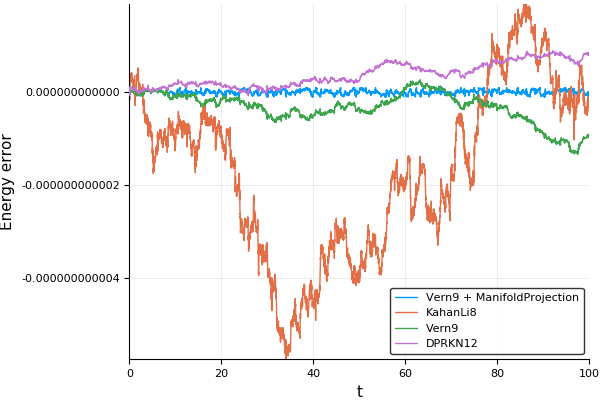

In [4]:
compare(tmax=1e2)

  1.517469 seconds (13.45 M allocations: 738.732 MiB, 45.60% gc time)
  0.967317 seconds (2.50 M allocations: 191.143 MiB, 38.26% gc time)
  4.926392 seconds (75.83 M allocations: 1.408 GiB, 43.40% gc time)
  0.210025 seconds (837.57 k allocations: 47.725 MiB, 24.16% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 8.327560863108374e-12
Vern9 max energy error: 2.6574298317427747e-12
DPRKN12 max energy error: 3.439026841078885e-12



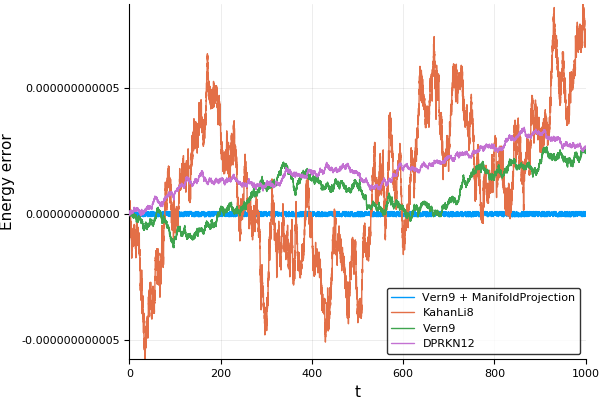

In [6]:
compare(tmax=1e3)

 19.914997 seconds (134.52 M allocations: 7.198 GiB, 58.04% gc time)
  1.117342 seconds (13.50 M allocations: 289.371 MiB, 17.06% gc time)
 93.795768 seconds (760.27 M allocations: 14.087 GiB, 68.25% gc time)
  5.844187 seconds (8.28 M allocations: 464.413 MiB, 72.60% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 8.394351880269824e-11
Vern9 max energy error: 1.7962520360015333e-11
DPRKN12 max energy error: 1.9610979506978765e-11



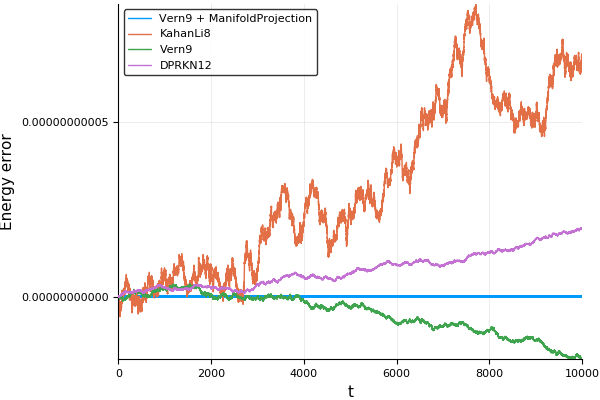

In [8]:
compare(tmax=1e4, saveat=0.1)

 50.956142 seconds (269.05 M allocations: 14.391 GiB, 66.78% gc time)
  4.076532 seconds (27.00 M allocations: 575.711 MiB, 54.15% gc time)
279.155262 seconds (1.52 G allocations: 28.155 GiB, 78.78% gc time)
 14.441447 seconds (16.55 M allocations: 923.939 MiB, 77.81% gc time)
Vern9 + ManifoldProjection max energy error: 9.947598300641403e-14
KahanLi8 max energy error: 8.394351880269824e-11
Vern9 max energy error: 2.1955770534987096e-11
DPRKN12 max energy error: 4.132516551180743e-11



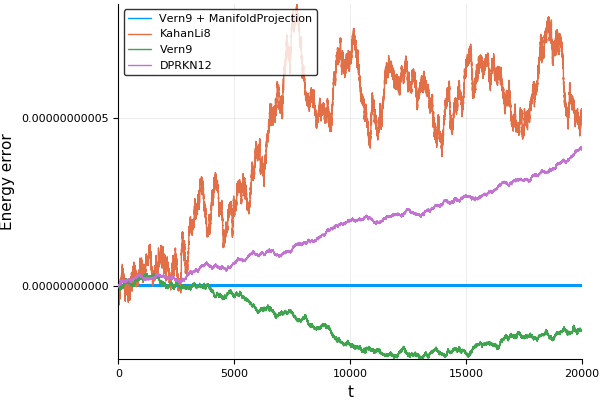

In [10]:
compare(tmax=2e4, saveat=0.1)

As we can see from the above plots, the only method that can give a very low energy error for long time simulation is the manifold projection one. In comparison with the Hénon-Heiles system we see that as the Hamiltonian got more complex, the energy error for the other integration methods increased significantly.